In [270]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [271]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = -100000

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 360.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = np.array([objective_function(c) for c in current_population_solutions])

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = np.array([objective_function(c) for c in children_population_solutions])
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0 and False:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [272]:
def get_points(x_start,y_start,components, alphas):
    x = [x_start]
    y = [y_start]
    alphas_r = np.radians(alphas)
    last_x, last_y = x_start, y_start
    for (c,a) in zip(components,alphas_r):
        x_curr = last_x + c * np.cos(a)
        y_curr = last_y + c * np.sin(a)
        last_x, last_y = x_curr, y_curr
        x.append(x_curr)
        y.append(y_curr)
    
    return x,y

In [273]:
def plot_robot(x,y,x_dest,y_dest):
    plt.figure()
#     plt.xlim(-10,10)
#     plt.ylim(-10,10)
    plt.plot(x_dest, y_dest, 'bo')
    plt.plot(x, y, '-bo',  c='black', markerfacecolor='red', markeredgecolor='k')

In [274]:
def get_objective_f(x_start,y_start,x_dest,y_dest,components):
    def obj_f(alphas):
        x,y = get_points(x_start,y_start,components, alphas)
        x_last = x[-1]
        y_last = y[-1]
        return -(x_last - x_dest)**2 - (y_last - y_dest)**2
    return obj_f

In [275]:
def solve(ratio, components, population_size, iterations):
    x_start = 0
    y_start = 0
    radius = np.sum(components)
    r = ratio * radius
    theta = np.radians(np.random.randint(360))
    x_dest = r*np.cos(theta)
    y_dest = r*np.sin(theta)
    
    obj_f = get_objective_f(x_start, y_start, x_dest, y_dest, components)
    best_solution_objective_value, best_solution, \
    log_objective_values, log_best_solutions, log_best_sigmas = es(
        obj_f, len(components), population_size, iterations, 2*population_size, 2, 50.0, 1/np.sqrt(2*len(components)), 1/np.sqrt(2*np.sqrt(len(components))), 10)

    x,y = get_points(x_start,y_start,components,best_solution)
    plot_robot(x,y,x_dest,y_dest)
    
    def init():
        line.set_data([], [])
        iteration_text.set_text('')
        obj_f_value_text.set_text('')
        return line, iteration_text, obj_f_value_text
    
    def animate(i):
        x,y = get_points(x_start,y_start,components,log_best_solutions[i])
        line.set_data(x, y)
        iteration_text.set_text('iteration = {}'.format(i))
        obj_f_value_text.set_text('obj_f = ' + '{:.2f}'.format(-obj_f(log_best_solutions[i])))
        return line, iteration_text, obj_f_value_text
    
    # Plotting robotic arm
    fig = plt.figure(figsize=(9,9))
    ax = plt.axes(xlim=(-max(r,radius)*1.2, max(r,radius)*1.2), ylim=(-max(r,radius)*1.2, max(r,radius)*1.2))
    
    circle_rrange = plt.Circle((0,0), radius, color='b',ls='--', fill=False, label='Robotic arm range:')
    circle_dest = plt.Circle((0,0), r, color='g', ls='--', fill=False, label='Destination point range:')
    line, = ax.plot([], [], '-bo',  c='black', markerfacecolor='red', markeredgecolor='k', lw=3)
    iteration_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    obj_f_value_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    start_p = ax.plot(x_start, y_start, 'bo')
    dest_p = ax.plot(x_dest, y_dest, 'go')
    ax.add_artist(circle_rrange)
    ax.add_artist(circle_dest)
    plt.legend((circle_rrange, circle_dest),('Robotic arm range:', 'Destination point range:'))
    anim = FuncAnimation(fig, animate, init_func=init,frames=iterations, interval=85, blit=True)
    anim.save('inverse_cinematics.gif', writer='imagemagick')

In [276]:
comps = np.random.randint(low=1,high=10,size=20)

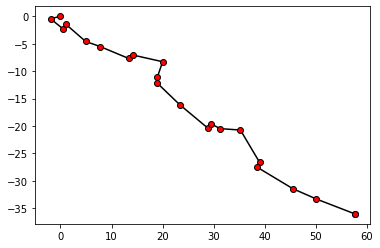

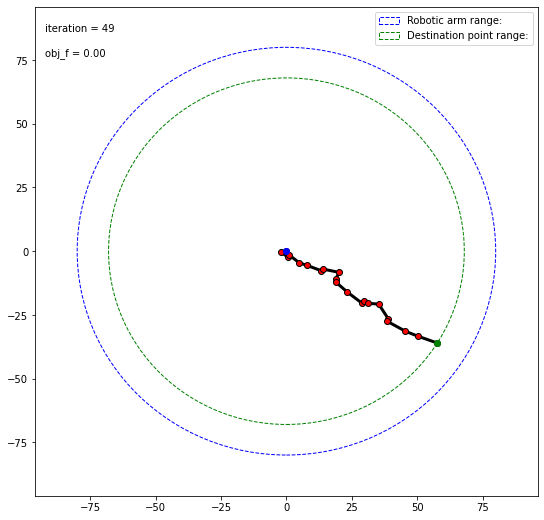

In [277]:
solve(0.85, comps, 30, 50)